## Imports

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

import joblib

import warnings
warnings.filterwarnings("ignore")

## Training and Testing Data Setup

In [2]:
# Preprocessed Loan Approval Dataset
df = pd.read_csv("loan_data_preprocessed.csv")

# Features
X = df.drop(['loan_status'], axis=1)
# Target 
y = df['loan_status']

In [3]:
# Split the data into training and testing sets (80% train, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Scale numeric features for applicable models
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(verbosity=-1, random_state=42),
    "KNearest" : KNeighborsClassifier(weights='distance')
}

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      6918
           1       0.72      0.43      0.54      2078

    accuracy                           0.83      8996
   macro avg       0.78      0.69      0.72      8996
weighted avg       0.82      0.83      0.81      8996



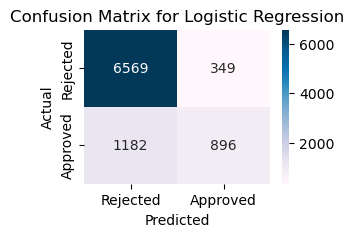


------------------------------

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6918
           1       0.91      0.69      0.78      2078

    accuracy                           0.91      8996
   macro avg       0.91      0.83      0.86      8996
weighted avg       0.91      0.91      0.91      8996



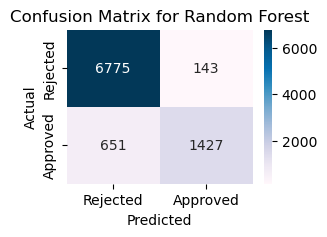


------------------------------

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6918
           1       0.91      0.70      0.79      2078

    accuracy                           0.91      8996
   macro avg       0.91      0.84      0.87      8996
weighted avg       0.91      0.91      0.91      8996



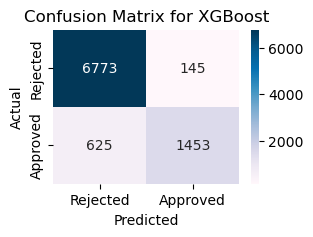


------------------------------

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      6918
           1       0.92      0.69      0.79      2078

    accuracy                           0.91      8996
   macro avg       0.92      0.84      0.87      8996
weighted avg       0.92      0.91      0.91      8996



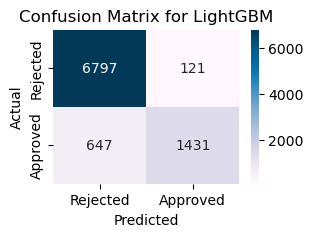


------------------------------

Classification Report for KNearest:

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6918
           1       0.65      0.52      0.58      2078

    accuracy                           0.82      8996
   macro avg       0.76      0.72      0.73      8996
weighted avg       0.81      0.82      0.82      8996



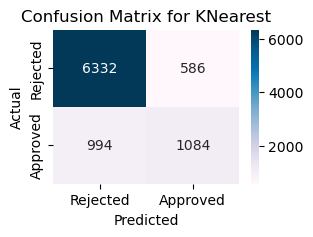


------------------------------

Model Performance Table:


,Model,Train Score,Test Score,Accuracy Score
0,Logistic Regression,0.835899,0.829813,0.829813
1,Random Forest,1.000000,0.911739,0.911739
2,XGBoost,0.943030,0.914406,0.914406
3,LightGBM,0.923577,0.914629,0.914629
4,KNearest,1.000000,0.824366,0.824366


In [6]:
results = []
all_feature_importances = []
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions on validation set
    y_pred = model.predict(X_test)
    
    # Train and Test Scores
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)

    # Save the model after training
    joblib.dump(model, f'{name}_model.pkl')
    
    results.append({
        'Model': name,
        'Train Score': train_score,
        'Test Score': test_score,
        'Accuracy Score': accuracy
    })
    
    # Classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        all_feature_importances.append({'Model': name})
        # Saving feature importances into a DataFrame and sorting it
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        
        # Saving the feature importances to CSV for later viewing
        feature_importance_df.to_csv(f'{name}_feature_importance.csv', index=False)
        
        # Saving feature importance to CSV
        feature_importance_df.to_csv(f'{name}_feature_importance.csv', index=False)
    print("\n" + "-"*30 + "\n")

results_df = pd.DataFrame(results)

# Display the model performance table
print("Model Performance Table:")
display(results_df)

In [7]:
from sklearn.model_selection import cross_val_score

# Loop through the models and apply cross-validation
cross_val_results = {}

for name, model in models.items():
    print(f"Running cross-validation for {name}...")
    
    # Apply 5-fold cross-validation on the training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Record the mean and standard deviation of cross-validation scores
    cross_val_results[name] = {
        'Mean Accuracy': cv_scores.mean(),
        'Std Accuracy': cv_scores.std()
    }
    
    print(f"Cross-validation results for {name}: Mean Accuracy = {cv_scores.mean():.4f}, Std Accuracy = {cv_scores.std():.4f}")
    print("\n" + "-"*30 + "\n")


Running cross-validation for Logistic Regression...
Cross-validation results for Logistic Regression: Mean Accuracy = 0.8490, Std Accuracy = 0.0046

------------------------------

Running cross-validation for Random Forest...
Cross-validation results for Random Forest: Mean Accuracy = 0.9097, Std Accuracy = 0.0048

------------------------------

Running cross-validation for XGBoost...
Cross-validation results for XGBoost: Mean Accuracy = 0.9117, Std Accuracy = 0.0041

------------------------------

Running cross-validation for LightGBM...
Cross-validation results for LightGBM: Mean Accuracy = 0.9127, Std Accuracy = 0.0059

------------------------------

Running cross-validation for KNearest...
Cross-validation results for KNearest: Mean Accuracy = 0.8600, Std Accuracy = 0.0028

------------------------------



Training on fold 1/5...
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 24.
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
Accuracy for fold 1: 0.8987
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5612
           1       0.85      0.66      0.74      1585

    accuracy                           0.90      7197
   macro avg       0.88      0.81      0.84      7197
weighted avg       0.90      0.90      0.89      7197



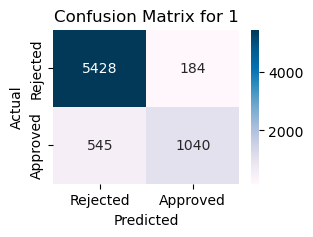

Training on fold 2/5...
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
Accuracy for fold 2: 0.8980
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5612
           1       0.90      0.61      0.72      1585

    accuracy                           0.90      7197
   macro avg       0.90      0.79      0.83      7197
weighted avg       0.90      0.90      0.89      7197



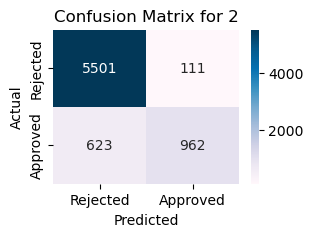

Training on fold 3/5...
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
Accuracy for fold 3: 0.8972
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5613
           1       0.86      0.63      0.73      1584

    accuracy                           0.90      7197
   macro avg       0.88      0.80      0.83      7197
weighted avg       0.89      0.90      0.89      7197



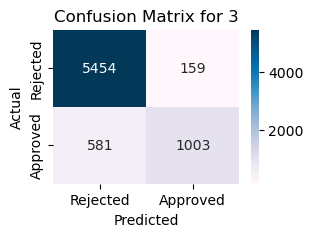

Training on fold 4/5...
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 27.
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
Accuracy for fold 4: 0.9012
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5613
           1       0.86      0.66      0.75      1584

    accuracy                           0.90      7197
   macro avg       0.88      0.82      0.84      7197
weighted avg       0.90      0.90      0.90      7197



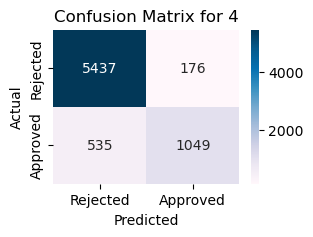

Training on fold 5/5...
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
Accuracy for fold 5: 0.8984
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5612
           1       0.87      0.63      0.73      1584

    accuracy                           0.90      7196
   macro avg       0.89      0.80      0.83      7196
weighted avg       0.90      0.90      0.89      7196



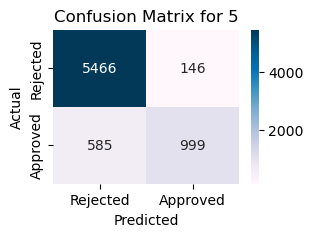

Average Accuracy across all folds: 0.8987


In [8]:
# Define the DNN model
def create_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))  # First hidden layer with 128 neurons
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(Dense(64, activation='relu'))  # Second hidden layer with 64 neurons
    model.add(Dropout(0.2))  # Dropout layer
    model.add(Dense(32, activation='relu'))  # Third hidden layer with 32 neurons
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    return model

# Initialize cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store the results
fold_accuracies = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train), 1):
    print(f"Training on fold {fold}/{kf.get_n_splits()}...")

    # Split the data into training and validation for this fold
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Create the model for each fold
    input_dim = X_train_fold.shape[1]
    model = create_dnn_model(input_dim)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define EarlyStopping callback for early termination if validation loss doesn't improve
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model on the current fold
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val_fold, y_val_fold),
                        verbose=0,
                        callbacks=[early_stopping])

    # Evaluate the model on the validation data for this fold
    y_pred_fold = (model.predict(X_val_fold) > 0.5).astype("int32")
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    fold_accuracies.append(accuracy)

    print(f"Accuracy for fold {fold}: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_pred_fold))

    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Plotting confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
    plt.title(f'Confusion Matrix for {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Calculate the average accuracy from all folds
mean_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy across all folds: {mean_accuracy:.4f}")

In [9]:
custom_test_data = pd.DataFrame([{
    'person_age': 10,
    'person_gender': 0, 
    'person_education': 0,  
    'person_income': 0.0,
    'person_emp_exp': 0,
    'loan_amnt': 15000000.0,
    'loan_int_rate': 0,
    'loan_percent_income': 0.0000001,
    'cb_person_cred_hist_length': 0,
    'credit_score': 0,

    # One-hot encoded home ownership
    'person_home_ownership_OTHER': False,
    'person_home_ownership_OWN': False,
    'person_home_ownership_RENT': False,

    # One-hot encoded loan intent
    'loan_intent_EDUCATION': False,
    'loan_intent_HOMEIMPROVEMENT': False,
    'loan_intent_MEDICAL': False,
    'loan_intent_PERSONAL': False,
    'loan_intent_VENTURE': False
}])

# Load the trained model
xgb_model = joblib.load('XGBoost_model.pkl')

# Predict
y_pred = xgb_model.predict(custom_test_data)

print("Loan prediction:", y_pred)  # 0 or 1

Loan prediction: [0]



Feature Importances for Random Forest:
                        Feature  Importance
0           loan_percent_income    0.215557
1                 loan_int_rate    0.188203
2                 person_income    0.162229
3    person_home_ownership_RENT    0.079537
4                     loan_amnt    0.078698
5                  credit_score    0.062270
6                    person_age    0.042043
7                person_emp_exp    0.037370
8    cb_person_cred_hist_length    0.034237
9              person_education    0.022476
10  loan_intent_HOMEIMPROVEMENT    0.013917
11    person_home_ownership_OWN    0.013530
12                person_gender    0.010536
13          loan_intent_MEDICAL    0.010414
14        loan_intent_EDUCATION    0.009734
15         loan_intent_PERSONAL    0.009234
16          loan_intent_VENTURE    0.009035
17  person_home_ownership_OTHER    0.000979


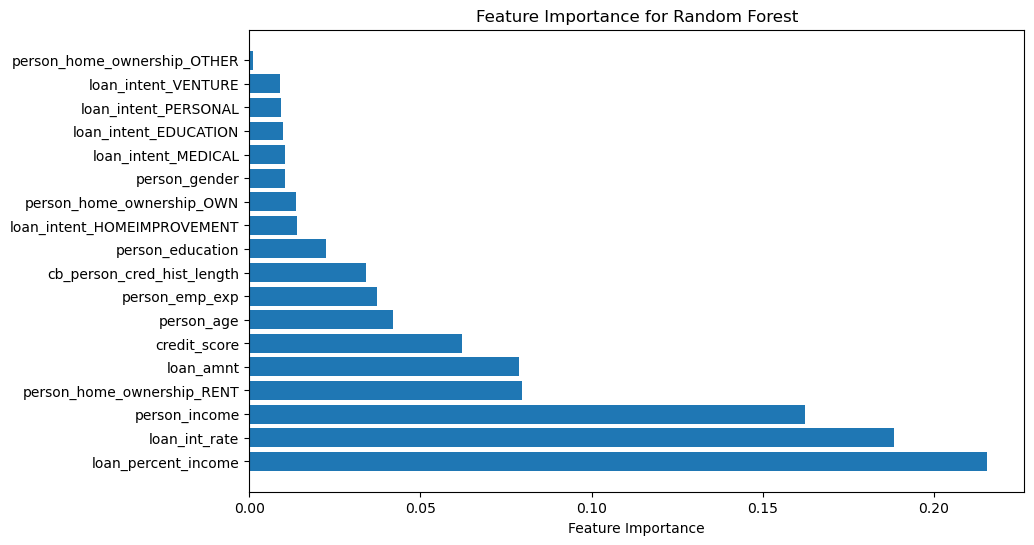


Feature Importances for XGBoost:
                        Feature  Importance
0    person_home_ownership_RENT    0.287651
1           loan_percent_income    0.159814
2     person_home_ownership_OWN    0.089588
3   loan_intent_HOMEIMPROVEMENT    0.065259
4                 loan_int_rate    0.065175
5           loan_intent_VENTURE    0.055333
6           loan_intent_MEDICAL    0.049260
7                 person_income    0.044580
8          loan_intent_PERSONAL    0.037277
9         loan_intent_EDUCATION    0.036265
10  person_home_ownership_OTHER    0.026479
11                   person_age    0.015598
12                    loan_amnt    0.014406
13   cb_person_cred_hist_length    0.011698
14             person_education    0.010890
15               person_emp_exp    0.010765
16                 credit_score    0.010729
17                person_gender    0.009232


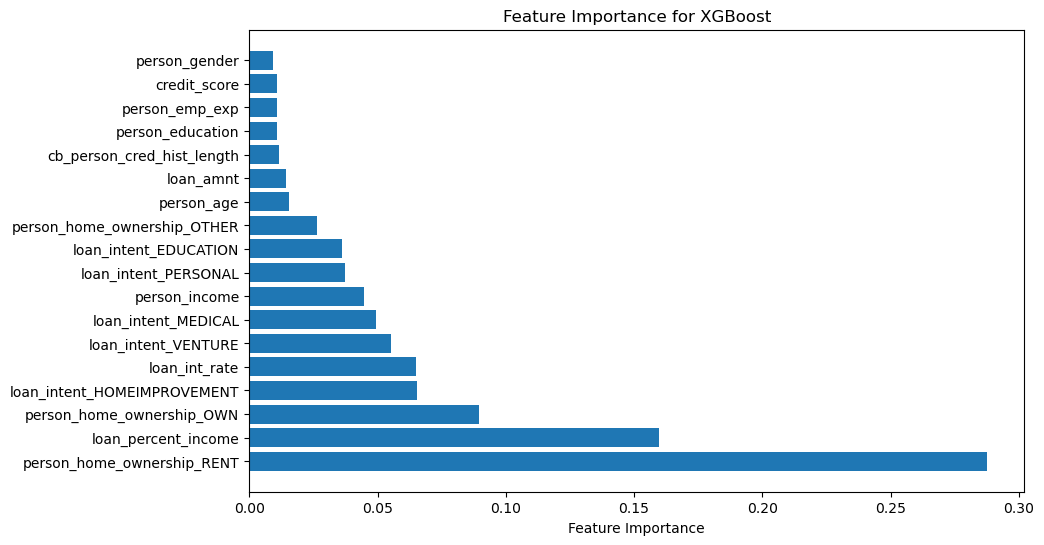


Feature Importances for LightGBM:
                        Feature  Importance
0                 person_income         839
1                 loan_int_rate         497
2                     loan_amnt         287
3           loan_percent_income         284
4                  credit_score         166
5                    person_age         164
6    person_home_ownership_RENT         113
7           loan_intent_VENTURE          90
8     person_home_ownership_OWN          89
9    cb_person_cred_hist_length          88
10  loan_intent_HOMEIMPROVEMENT          79
11               person_emp_exp          77
12          loan_intent_MEDICAL          60
13        loan_intent_EDUCATION          57
14         loan_intent_PERSONAL          45
15             person_education          33
16                person_gender          22
17  person_home_ownership_OTHER          10


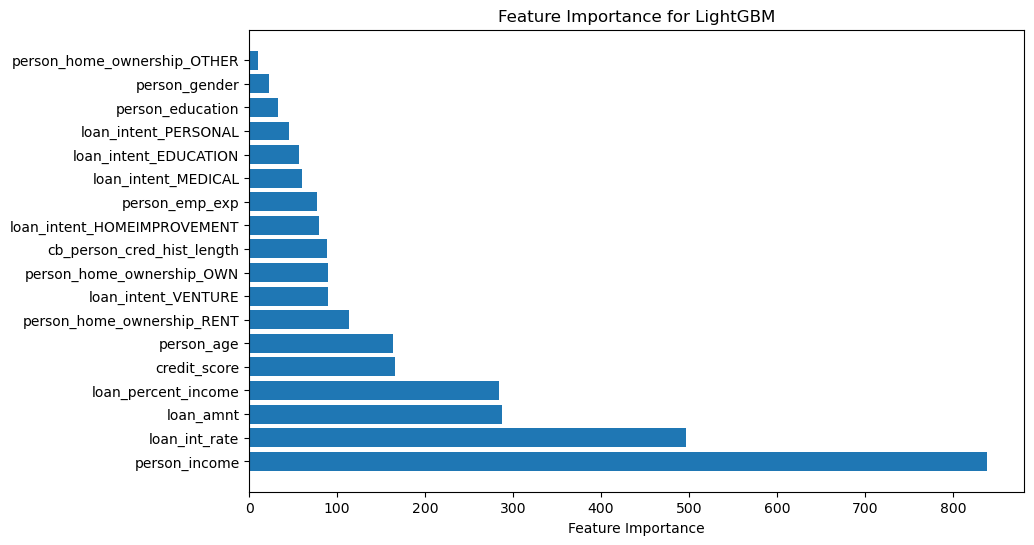

In [10]:
for importance_data in all_feature_importances:
    model_name = importance_data['Model']
    
    # Construct the correct file name based on the model name
    feature_importance_file = f'{model_name}_feature_importance.csv'
    
    try:
        # Load the saved feature importance CSV for each model
        feature_importance_df = pd.read_csv(feature_importance_file)
        
        print(f"\nFeature Importances for {model_name}:")
        print(feature_importance_df)
        
        # Plotting the feature importance for each model
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Feature Importance')
        plt.show()
    
    except FileNotFoundError:
        print(f"Feature importance file for {model_name} not found. Please check if the model was trained and saved properly.")

In [11]:
all_feature_importances

[{'Model': 'Random Forest'}, {'Model': 'XGBoost'}, {'Model': 'LightGBM'}]

In [12]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22.0,0,4,71948.0,0,35000.0,16.02,0.49,3.0,561,1,False,False,True,False,False,False,True,False
1,21.0,0,3,12282.0,0,1000.0,11.14,0.08,2.0,504,0,False,True,False,True,False,False,False,False
2,25.0,0,3,12438.0,3,5500.0,12.87,0.44,3.0,635,1,False,False,False,False,False,True,False,False
3,23.0,0,1,79753.0,0,35000.0,15.23,0.44,2.0,675,1,False,False,True,False,False,True,False,False
4,24.0,1,4,66135.0,1,35000.0,14.27,0.53,4.0,586,1,False,False,True,False,False,True,False,False
